In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import os

In [2]:
sns.set_style('white')

In [3]:
DATA_SOURCE = './data'
DATA_TYPE = 'recommendations'

In [4]:
DATA_PATH = Path(f'../{DATA_SOURCE}/{DATA_TYPE}')
DATA_PATH

PosixPath('../data/recommendations')

In [5]:
listings_df = pd.read_csv(DATA_PATH/'listings.csv')
# listings_summary_df = pd.read_csv(DATA_PATH/'listings_summary.csv')
# neighbourhoods_df = pd.read_csv(DATA_PATH/'neighbourhoods.csv')
reviews_df = pd.read_csv(DATA_PATH/'reviews.csv')
# reviews_summary_df = pd.read_csv(DATA_PATH/'reviews_summary.csv')

/var/folders/nz/g6pchq3j0k1cyfvxg0_ld34c0000gp/T/ipykernel_96863/2844973500.py:1: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  listings_df = pd.read_csv(DATA_PATH/'listings.csv')


In [6]:
listings_null_percentage = listings_df.isna().sum()/listings_df.shape[0]
listings_null_percentage

id                                              0.000000
listing_url                                     0.000000
scrape_id                                       0.000000
last_scraped                                    0.000000
name                                            0.000294
                                                  ...   
calculated_host_listings_count                  0.000000
calculated_host_listings_count_entire_homes     0.000000
calculated_host_listings_count_private_rooms    0.000000
calculated_host_listings_count_shared_rooms     0.000000
reviews_per_month                               0.235177
Length: 106, dtype: float64

<Axes: >

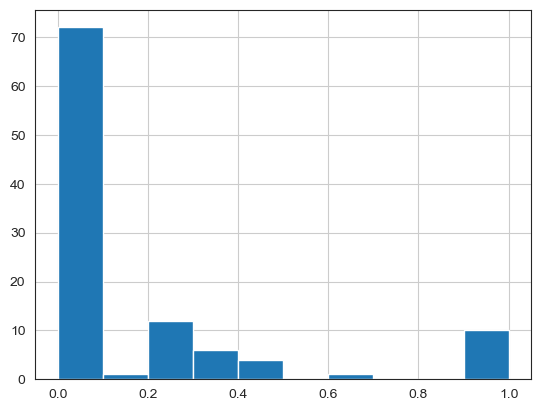

In [7]:
listings_null_percentage.hist()

### Initial idea of exploration and selecting features that felt relevant to be used. However these features can be used as embeddings or vectors for similarity matching. The approach that I took need not require them at this stage, but with time we can evolve and convert them into vectors for item-item recommendation

In [8]:
listing_cols_to_drop = listings_null_percentage[listings_null_percentage>0.35].index.to_list() + \
                        [col for col in listings_df.columns if str(col).find('url') != -1] + \
                        [col for col in listings_df.columns if str(col).find('name')!=-1] + \
                        [col for col in listings_df.columns if col.find('minimum') !=-1 or col.find('maximum') !=-1][2:] + \
                        ['calendar_last_scraped', 'street', 'neighbourhood_cleansed', 'city' , 'state', 'zipcode', 'market', 'smart_location', 'country_code',
                         'country', 'scrape_id', 'summary']

In [62]:
listings_df.drop(columns=listing_cols_to_drop, inplace=True)

['neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'xl_picture_url',
 'host_about',
 'host_acceptance_rate',
 'neighbourhood_group_cleansed',
 'square_feet',
 'weekly_price',
 'monthly_price',
 'license',
 'jurisdiction_names',
 'listing_url',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_url',
 'host_thumbnail_url',
 'host_picture_url',
 'name',
 'host_name',
 'jurisdiction_names',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_last_scraped',
 'street',
 'neighbourhood_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'scrape_id',
 'summary']

In [10]:
reviews_df['date'] = pd.to_datetime(reviews_df['date'])

listings_df['host_since'] = pd.to_datetime(listings_df['host_since'])
listings_df['last_scraped'] = pd.to_datetime(listings_df['last_scraped'])

listings_df['first_review'] = pd.to_datetime(listings_df['first_review'])
listings_df['last_review'] = pd.to_datetime(listings_df['last_review'])


In [11]:
def convert_price(df_col):
    return df_col.str.replace('$','').str.replace('.','').str.replace(',','').astype(float)/100

In [12]:
price_cols = ['price','extra_people']
for col in price_cols:
    listings_df[col] = convert_price(listings_df[col])

/var/folders/nz/g6pchq3j0k1cyfvxg0_ld34c0000gp/T/ipykernel_96863/2767996772.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  return df_col.str.replace('$','').str.replace('.','').str.replace(',','').astype(float)/100


In [13]:
def to_boolean(df_col):
    return df_col.replace({'f':0,'t':1}).astype('boolean')

In [14]:
bool_cols = ['host_is_superhost','host_has_profile_pic', 'host_identity_verified', 'is_location_exact','has_availability','requires_license','instant_bookable',
             'is_business_travel_ready','require_guest_profile_picture','require_guest_phone_verification']

for col in bool_cols:
    listings_df[col] = to_boolean(listings_df[col])

In [15]:
rate_cols = [col for col in listings_df.columns if col.find('rate')!= -1]

In [16]:
# TODO : handle situation when more than one
if len(rate_cols)==1:
    rate_cols = rate_cols[0]

In [17]:
listings_df[rate_cols] = listings_df[rate_cols].replace(np.nan, '-1%').str.replace('%','').astype('float')


In [18]:
#TODO: more work to do on the listings dataframe. lets look at review dataframe now

### What I did above was mostly exploring and preparing the listings dataset, which can be of importance based on approaches taken

### Looking at the reviews_df. It can be seen that users have reviews placed. These are implicit ratings and the approach is to find a score for these comments

In [19]:
reviews_df.rename(columns={'date':'review_date'}, inplace=True)

In [20]:
reviews_df

,listing_id,id,review_date,reviewer_id,reviewer_name,comments
0,11551,30672,2010-03-21,93896,Shar-Lyn,"The flat was bright, comfortable and clean and..."
1,11551,32236,2010-03-29,97890,Zane,We stayed with Adriano and Valerio for a week ...
2,90700,337227,2011-06-27,311071,Miqua,it was all in all the perfect week!\r\nchilton...
3,90700,378738,2011-07-17,224367,Prateek,"I'll start with the host, and then move on to ..."
4,90700,543840,2011-09-18,1115024,Jennifer,Great location. Plenty to do just steps outsid...
...,...,...,...,...,...,...
1486231,39740287,559509688,2019-11-04,182032644,Isabel,"A very good stay, I would repeat for sure."
1486232,22701498,558667202,2019-11-03,65955902,Shereen,"Set in a lovely development with onsite bar, c..."
1486233,38398365,552239161,2019-10-21,60436496,Chee Ling,(Website hidden by Airbnb) a.best owner and ge...
1486234,38398365,559541617,2019-11-04,97684167,Carolyn,This flat is perfection! Everything you need i...


In [21]:
combined_df = pd.merge(listings_df,reviews_df,left_on='id', right_on='listing_id',how='left')

### I approached a collaborative filtering based on the weights proposed by the sentiments, since we have a lot of users and listings, and pre processing would take time, I shortlisted the listings with major feedback to ensure we remove sparsity of the matrix, Of course these would lead to cold-start problems, however the idea was to recommend for returning users

In [22]:
top_150 = combined_df.groupby('listing_id').comments.count().sort_values(ascending=False).head(400)

In [23]:
combined_df[combined_df.listing_id.isin(top_150.index)]

,id_x,last_scraped,space,description,experiences_offered,host_id,host_since,host_location,host_response_time,host_response_rate,...,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,listing_id,id_y,review_date,reviewer_id,reviewer_name,comments
342,90700,2019-11-06,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,491286,2011-04-07,"London, England, United Kingdom",within a day,86.0,...,2,0,0,3.33,90700.0,337227.0,2011-06-27,311071.0,Miqua,it was all in all the perfect week!\r\nchilton...
343,90700,2019-11-06,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,491286,2011-04-07,"London, England, United Kingdom",within a day,86.0,...,2,0,0,3.33,90700.0,378738.0,2011-07-17,224367.0,Prateek,"I'll start with the host, and then move on to ..."
344,90700,2019-11-06,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,491286,2011-04-07,"London, England, United Kingdom",within a day,86.0,...,2,0,0,3.33,90700.0,543840.0,2011-09-18,1115024.0,Jennifer,Great location. Plenty to do just steps outsid...
345,90700,2019-11-06,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,491286,2011-04-07,"London, England, United Kingdom",within a day,86.0,...,2,0,0,3.33,90700.0,563397.0,2011-09-24,991486.0,Michelle,"Great location, perfect place and size for my ..."
346,90700,2019-11-06,This charming 1 bedroom with en-suite bathroom...,This is a home not a hotel - for the cost gues...,none,491286,2011-04-07,"London, England, United Kingdom",within a day,86.0,...,2,0,0,3.33,90700.0,579511.0,2011-09-28,1181648.0,Michael,Highly recommended. Perfect location -- aroun...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146436,23158183,2019-11-06,The space Situated in the basement with plenty...,My Place is situated in the Belgravia area in ...,none,172140241,2018-02-07,GB,within an hour,100.0,...,0,2,0,11.50,23158183.0,555215135.0,2019-10-27,25804328.0,Hywel,A very affordable place in a good location.
1146437,23158183,2019-11-06,The space Situated in the basement with plenty...,My Place is situated in the Belgravia area in ...,none,172140241,2018-02-07,GB,within an hour,100.0,...,0,2,0,11.50,23158183.0,555950330.0,2019-10-28,59831259.0,So,"地點非常方便,走路去大笨鐘20分鐘,還可以存放行李｡\n房間小但有電視小洗手盆風扇,我們入住..."
1146438,23158183,2019-11-06,The space Situated in the basement with plenty...,My Place is situated in the Belgravia area in ...,none,172140241,2018-02-07,GB,within an hour,100.0,...,0,2,0,11.50,23158183.0,556761725.0,2019-10-30,86102616.0,Alex,Great location! Small room but perfect for pri...
1146439,23158183,2019-11-06,The space Situated in the basement with plenty...,My Place is situated in the Belgravia area in ...,none,172140241,2018-02-07,GB,within an hour,100.0,...,0,2,0,11.50,23158183.0,557566331.0,2019-11-01,150278380.0,Ludivine,Pour le rapport qualité prix il ne faut pas s’...


<Axes: >

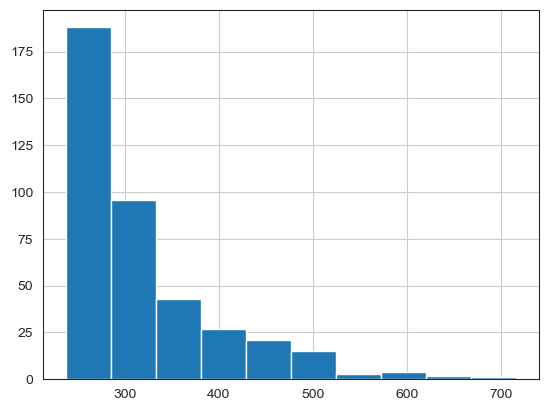

In [24]:
sampled_df = combined_df[combined_df.listing_id.isin(top_150.index)].copy()
sampled_df.groupby('listing_id')['reviewer_id'].count().hist()

In [25]:
combined_df['comments'] = combined_df['comments'].astype(str)

In [26]:
import re
def clean_strings(input_string):
    input_string = re.sub(r'[^\x00-\x7f]',r' ',input_string)
    input_string = re.sub(r'.*\/[a-zA-Z]',r'', input_string)
    input_string = re.sub(r'.*\\\[a-zA-Z]',r'', input_string)
    input_string = re.sub(r'[^a-zA-Z0-9\s]', '', input_string)
    return input_string

In [27]:
from langdetect import detect

def detect_language(input_string):
    try:
        lang = detect(input_string)
    except Exception as e:
        lang = 'NA'

    return lang

### Trying to detect english language comments and filter them out

In [28]:
%%time
sampled_df['detected_language'] = sampled_df['comments'].apply(lambda row: detect_language(row))

CPU times: user 3min 22s, sys: 1.98 s, total: 3min 24s
Wall time: 3min 32s


<Axes: >

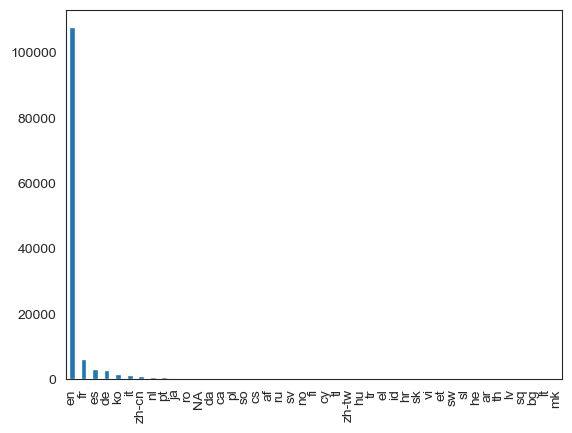

In [29]:
sampled_df.detected_language.value_counts().plot(kind='bar')

In [30]:
english_df = sampled_df[sampled_df['detected_language']=='en'].copy()
english_df.shape

(107657, 71)

### Applied a few string cleaning process to derive sentiments

In [31]:
%%time
english_df['cleaned_comments'] = english_df.comments.apply(lambda row: clean_strings(row))

CPU times: user 9.74 s, sys: 40.2 ms, total: 9.78 s
Wall time: 9.76 s


In [32]:
english_df[['cleaned_comments','comments']]

,cleaned_comments,comments
342,it was all in all the perfect week\r\nchilton ...,it was all in all the perfect week!\r\nchilton...
343,Ill start with the host and then move on to th...,"I'll start with the host, and then move on to ..."
344,Great location Plenty to do just steps outside...,Great location. Plenty to do just steps outsid...
345,Great location perfect place and size for my b...,"Great location, perfect place and size for my ..."
346,Highly recommended Perfect location around t...,Highly recommended. Perfect location -- aroun...
...,...,...
1146429,Pros quiet pleasant area Clean comfy\nCons sha...,"Pros: quiet, pleasant area. Clean, comfy.\nCon..."
1146430,Cozy room and super convenient checkin just be...,"Cozy room and super convenient check-in, just ..."
1146436,A very affordable place in a good location,A very affordable place in a good location.
1146438,Great location Small room but perfect for pric...,Great location! Small room but perfect for pri...


In [33]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kazi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [35]:
def get_sentiment(input_string):
    score = SIA().polarity_scores(input_string)
    return score['compound']

In [36]:
SENTIMENT_DIR = '../sentiment_ops'

if  not os.path.exists(SENTIMENT_DIR):
    os.makedirs(SENTIMENT_DIR)

In [37]:
import os
vader_sentiment_list_file = os.path.join(SENTIMENT_DIR, 'airbnb-sentiment.pkl')

In [38]:
%%time
if os.path.isfile(vader_sentiment_list_file):
    print('Delete existing file')
    os.remove(vader_sentiment_list_file)

print('Generating new vadar sentiments')
vader_sentiment_list = english_df['cleaned_comments'].apply(lambda x: get_sentiment(x))
vader_sentiment_list.to_pickle(vader_sentiment_list_file)
print(f'Saved in directory {vader_sentiment_list_file}')

Delete existing file
Generating new vadar sentiments
Saved in directory ../sentiment_ops/airbnb-sentiment.pkl
CPU times: user 4min 43s, sys: 750 ms, total: 4min 43s
Wall time: 4min 44s


In [39]:
english_df['vader_sentiment_score'] = vader_sentiment_list

In [40]:
from sklearn.preprocessing import MinMaxScaler

### Ensuring the sentiments_score range between 0 and 1

In [41]:
scaler = MinMaxScaler()
scaler.fit(english_df[['vader_sentiment_score']])
english_df['sentiment_score'] = scaler.transform(english_df[['vader_sentiment_score']])

In [42]:
english_df['sentiment_score_perc'] = np.ceil(english_df['sentiment_score'] * 100).astype(int)

In [43]:
list_user_info = english_df[['listing_id','reviewer_id','sentiment_score']].copy()

In [44]:
%%time
user_list_matrix = list_user_info.pivot_table(index = ["reviewer_id"],columns = ["listing_id"],values = "sentiment_score")


CPU times: user 280 ms, sys: 155 ms, total: 434 ms
Wall time: 489 ms


In [45]:
user_list_matrix.fillna(0,inplace=True)

### Visualising the sparsity of the matrix

<Axes: xlabel='listing_id', ylabel='reviewer_id'>

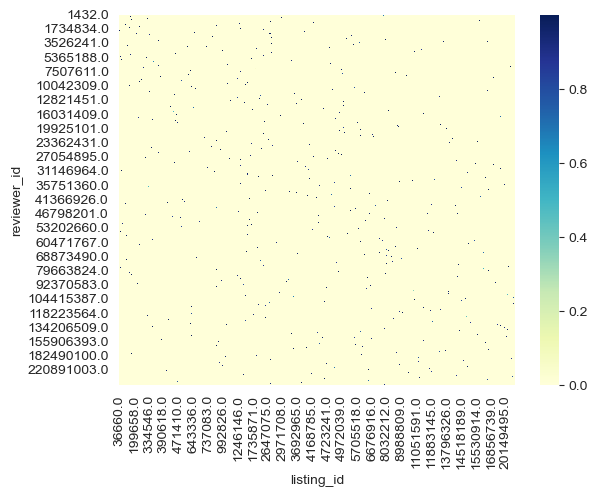

In [46]:
sns.heatmap(user_list_matrix, cmap="YlGnBu")

### Let's look at a property that was visited and see how the similar properties are suggested

In [47]:
visited_list_id = 1013117

In [48]:
user_list_matrix

listing_id,36660.0,38605.0,42010.0,47192.0,52940.0,64429.0,84223.0,85191.0,90700.0,97178.0,...,20149495.0,20264430.0,20437035.0,20704116.0,21108020.0,21391504.0,21438138.0,22142153.0,23020112.0,23158183.0
reviewer_id,,,,,,,,,,,,,,,,,,,,,
1432.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1510.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.90352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2723.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2735.0,0.936765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2881.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304032353.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304337829.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
304876906.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
%%time
similar_id_scores  = user_list_matrix.corrwith(user_list_matrix[visited_list_id ])

CPU times: user 223 ms, sys: 40.8 ms, total: 263 ms
Wall time: 263 ms


In [50]:
top = 10
similar_id_scores.sort_values(ascending=False).head(top)

listing_id
1013117.0     1.000000
2761866.0     0.002389
3708776.0     0.002159
13975451.0    0.001716
391392.0      0.001707
392045.0      0.001395
970701.0      0.001252
632672.0      0.000807
877864.0     -0.000408
388767.0     -0.000535
dtype: float64

### Counting reviews of the people who stayed in the selected listed place to find out their other listed stays for comparison

In [51]:
review_counts = reviews_df[reviews_df.reviewer_id.isin(
                    reviews_df[reviews_df.listing_id==visited_list_id].reviewer_id.to_list()
)].groupby('reviewer_id')['listing_id'].count()

### For all the people who had more than one reviews, the top 10 recall metrics is calculated for each of them

In [52]:
availability = {}
for reviewer in review_counts[review_counts>1].index:
    is_available = reviews_df[reviews_df.reviewer_id==reviewer].listing_id.isin(similar_id_scores.sort_values(ascending=False).head(top).index).sum()
    availability[reviewer] = is_available

In [53]:
availability_df = pd.DataFrame(availability,index=['topKrecall']).T

### Evaluation criteria

In [54]:
topKrecall = (availability_df >1).sum()/len(availability_df)
topKrecall

topKrecall    0.3125
dtype: float64

Around 31 % of the users had tried out the listings that was proposed by the system based on their visit to a selected listing id = 1013117

In [55]:
#TODO : Unfinished tasks



### Another approach to consider are embeddings and features
- We can use the user embeddings
- Listed embeddings
- both these would be used to predict the sentiment_score

### Another possible way is to use these user and user features through matrix decomposition


In [56]:
all_users = list_user_info['reviewer_id'].unique()
all_listings = list_user_info['listing_id'].unique()

In [57]:
import tensorflow as tf

# user pipeline
user_input = tf.keras.layers.Input(shape=(1,), name="user")
user_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_users)(user_input)
user_embedding = tf.keras.layers.Embedding(input_dim=len(all_users)+1, output_dim=32)(user_as_integer)

# list pipeline
list_input = tf.keras.layers.Input(shape=(1,), name="list")
list_as_integer = tf.keras.layers.IntegerLookup(vocabulary=all_listings)(list_input)
list_embedding = tf.keras.layers.Embedding(input_dim=len(all_listings)+1, output_dim=32)(list_as_integer)

# dot product
dot = tf.keras.layers.Dot(axes=2)([user_embedding, list_embedding])
flatten = tf.keras.layers.Flatten()(dot)

# model input/output definition
model = tf.keras.Model(inputs=[user_input, list_input], outputs=flatten)

model.compile(loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [58]:
model.fit(
    x={
        "user": list_user_info['reviewer_id'].to_numpy(),
        "list": list_user_info['listing_id'].to_numpy()
    },
    y=list_user_info['sentiment_score'],
    batch_size=256,
    epochs=100,
    validation_split=0.1, # for early stopping
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)
    ],
)

Epoch 1/100
379/379 [==============================] - 1s 3ms/step - loss: 0.5460 - mean_absolute_error: 0.6389 - val_loss: 0.7949 - val_mean_absolute_error: 0.8783
Epoch 2/100
379/379 [==============================] - 1s 3ms/step - loss: 0.4037 - mean_absolute_error: 0.4689 - val_loss: 0.7941 - val_mean_absolute_error: 0.8759
Epoch 3/100
379/379 [==============================] - 1s 3ms/step - loss: 0.3826 - mean_absolute_error: 0.4562 - val_loss: 0.7940 - val_mean_absolute_error: 0.8759
Epoch 4/100
379/379 [==============================] - 1s 3ms/step - loss: 0.3524 - mean_absolute_error: 0.4378 - val_loss: 0.7942 - val_mean_absolute_error: 0.8763
